- Related works:
    - Dialogue-Act Prediction of Future Responses based on Conversation History (http://aclanthology.lst.uni-saarland.de/P19-2027.pdf)
    - DeliData: A dataset for deliberation in multi-party problem solving (https://arxiv.org/pdf/2108.05271.pdf)
    - Identifying Agreement/Disagreement in Conversational Speech: A Cross-lingual Study (https://www.sri.com/wp-content/uploads/2021/12/identifying_agreement-disagreement_in_conversational_speech.pdf)
    - The Role of Conversational Structure in Agreement and Disagreement Detection in Online Discussions (https://aclanthology.org/W15-4625.pdf)
    - Modeling Long-Range Context for Concurrent Dialogue Acts Recognition https://arxiv.org/pdf/1909.00521.pdf
    - User Satisfaction Estimation with Sequential Dialogue Act Modeling in Goal-oriented Conversational Systems https://arxiv.org/pdf/2202.02912.pdf
    - 

- Implementatoin based on https://github.com/coastalcph/hierarchical-transformers and LongFormer

- Experiments:
    - Predict understanding vs non-understanding signals in dialogue -> That indicates quality of explanation (baseline)
    - LongFormer that consumes all the text up to window_size and predict the quality
    - Modeling quality by the degree of non-understanding explanation_moves in the dialogue: Average probability of all uternaces of being a non-understanding explanation move.
    - RQ: Can we predict ahead whether the dialogue will lead to non-understanding?

In [1]:
%load_ext autoreload

In [2]:
import sys
import os
import wandb

sys.path.insert(0, '../src-py')

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

#wandb.init(project="test-project", entity="milad-it")

In [3]:
import json
import pandas as pd
import numpy as np
import glob 
from tabulate import tabulate
import math
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

pd.set_option('display.max_colwidth', None)

In [4]:
def load_and_prepare_df(path, quality_df_path):
    eli5_df  = pd.read_pickle(path)
    eli5_dlg_quality_df = pd.read_csv(quality_df_path)
    quality_scores = pd.Series(eli5_dlg_quality_df.rating_label.values, index = eli5_dlg_quality_df.task_id).to_dict()
    
    eli5_df = eli5_df.groupby('task_id').agg({'turn_text': lambda rows: list(rows),
                                          'topic': lambda rows: list(rows)[0],
                                          'topic_func_label': lambda rows: list(rows),
                                          'dlg_act_label': lambda rows: list(rows),
                                          'exp_type_label' : lambda rows: list(rows),
                                          'exp_act_label': lambda rows: list(rows)}).reset_index()

    eli5_df['labels'] = eli5_df.task_id.apply(lambda x: quality_scores[x])
    eli5_df['input_texts'] = eli5_df.turn_text.apply(lambda row: [x['text'] for x in row])

    eli5_df['exp_act_label'] =  eli5_df['exp_act_label'].apply(lambda row: [int(x[2:4]) for x in row])
    eli5_df['dlg_act_label'] =  eli5_df['dlg_act_label'].apply(lambda row: [int(x[2:4]) for x in row])
    eli5_df['topic_func_label'] =  eli5_df['topic_func_label'].apply(lambda row: [int(x[2:4]) for x in row])

    print('Maximum seq num:', max([len(x) for x in eli5_df.input_texts.tolist()]))
    print('Maximum seq len:', max([len(turn.split(' ')) for turns in eli5_df.input_texts.tolist() for turn in turns]))
    print('Data size:', len(eli5_df))
    return eli5_df

## Experiments on HIT models:

In [10]:
sys.path.insert(0, '../../../third-party/hierarchical-transformers/')

In [11]:
%autoreload

from models.hat import HATConfig, HATTokenizer, HATForSequenceClassification
from models.longformer import LongformerTokenizer, LongformerModelForSequenceClassification
from language_modelling.data_collator import DataCollatorForDocumentClassification
from datasets import load_dataset, Dataset, load_metric
from sklearn.metrics import f1_score

from utils import *

Device:  cuda


In [ ]:
eli5_training_df= load_and_prepare_df('../../data/eli5_ds/annotation-results/MACE-measure/final_mace_predictions_training.pkl', '../../data/eli5_ds/annotation-results/MACE-measure/final_mace_rating_predictions.csv')
eli5_testing_df = load_and_prepare_df('../../data/eli5_ds/annotation-results/MACE-measure/final_mace_predictions_testing.pkl', '../../data/eli5_ds/annotation-results/MACE-measure/final_mace_rating_predictions.csv')

In [ ]:
model_name_or_path = 'kiddothe2b/hierarchical-transformer-base-4096'

In [ ]:
def train_and_evaluate_hat_model(model_name_or_path, output_dir, df, wandb_run_name, input_clm='turn_text', 
                                 num_train_epochs=5, eval_steps=500, lr=2e-6, batch_size=4, 
                                 max_seq_length=256, max_num_sequences=40, extra_encoder_configs=[]):


    model_revision="main"
    do_lower_case=False
    pooling="max" #Which pooling method to use (max, cls, attentive)

    config = HATConfig.from_pretrained(
        model_name_or_path,
        num_labels=1,
        finetuning_task="document-classification",
        revision="main",
        use_auth_token=None
    )

    tokenizer = HATTokenizer.from_pretrained(
        model_name_or_path,
        do_lower_case=False,
        revision=model_revision,
        use_auth_token=None,
    )

    wandb.init(settings=wandb.Settings(start_method="fork"), project="test-project", entity="milad-it", name='{}-hat-former'.format(wandb_run_name))

    rmse_scores = []

    
    #split by topic
    topics  = df.topic.unique()
    train_topics, test_topics  = train_test_split(topics, test_size=0.2, shuffle=True, random_state=123)
    train_topics, valid_topics = train_test_split(train_topics, test_size=0.2, shuffle=True, random_state=123)
    
    train_df = df[df.topic.isin(train_topics)]
    valid_df = df[df.topic.isin(valid_topics)]
    test_df  = df[df.topic.isin(test_topics)]
    
    #balance the data
    train_df, y = ros.fit_resample(train_df, train_df['labels'])
    train_df['labels'] = y
    print(train_df.labels.value_counts())

    training_ds = Dataset.from_pandas(train_df)
    valid_ds    = Dataset.from_pandas(valid_df)
    test_ds     = Dataset.from_pandas(test_df)

    training_ds = training_ds.map(lambda examples: preprocess_hat_function(tokenizer, examples, max_seq_length, False), 
                        batched=True, load_from_cache_file=False, remove_columns=['labels'])
    valid_ds    = valid_ds.map(lambda examples: preprocess_hat_function(tokenizer, examples, max_seq_length, False), 
                        batched=True, load_from_cache_file=False, remove_columns=['labels'])
    test_ds     = test_ds.map(lambda examples: preprocess_hat_function(tokenizer, examples, max_seq_length, False), 
                        batched=True, load_from_cache_file=False, remove_columns=['labels'])

    print('Training {}, Valid {}, and Test {}'.format(len(training_ds), len(valid_ds), len(test_ds)))

    if extra_encoder_configs != []:
        model = MyHATForSequenceClassification.from_pretrained(
            model_name_or_path,
            pooling=pooling,
            config=config,
            revision=model_revision,
            use_auth_token=None,
            extra_encoders_configs=extra_encoder_configs)
    else:
        model = HATForSequenceClassification.from_pretrained(
            model_name_or_path,
            pooling=pooling,
            config=config,
            revision=model_revision,
            use_auth_token=None
        )


    args = TrainingArguments(
            output_dir= '{}/{}/-{}-fold'.format(output_dir, wandb_run_name, 0),
            overwrite_output_dir=True,
            evaluation_strategy = "steps",
            save_strategy = "steps",
            logging_strategy="steps",
            save_total_limit=5,
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_train_epochs,
            weight_decay=0.01,
            eval_steps=eval_steps,
            logging_steps=eval_steps,
            load_best_model_at_end=True,
            metric_for_best_model='rmse'
        )


    trainer = Trainer(
        model,
        args,
        train_dataset=training_ds,
        eval_dataset=valid_ds,
        compute_metrics=lambda x: compute_metrics(x),
        tokenizer=tokenizer
    )

    trainer.train()

    eval_results = trainer.evaluate(test_ds)
    wandb.log(eval_results)
    rmse_scores.append(eval_results['eval_rmse'])
    model.save_pretrained('{}/{}/{}-fold'.format(output_dir, wandb_run_name, 0))
    test_ds.to_json('{}/{}/{}-fold/test_set.json'.format(output_dir, wandb_run_name, 0))
    json.dump(eval_results, open('{}/{}/{}-fold/eval_results.json'.format(output_dir, wandb_run_name, 0), 'w'))

    wandb.finish()
        
    return rmse_scores

### Train the basic hat model:

In [14]:
exp_types_rmse_scores = train_and_evaluate_hat_model(model_name_or_path, '../data/quality_models/hat-models/', 
                                                     eli5_annotation_df[['topic', 'input_texts', 'labels']], 'hat-model-test-no-encoder',
                                                     extra_encoder_configs=[],
                                                     num_train_epochs=5, lr=2e-5, batch_size=8,  eval_steps=50)

wandb: Currently logged in as: miladalsh-it (milad-it). Use `wandb login --relogin` to force relogin


Parameter 'function'=<function train_and_evaluate_hat_model.<locals>.<lambda> at 0x7f338593fd30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Training 410, Valid 73, and Test 75


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing HATForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing HATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['pooler.dense.bias', 'c

Step,Training Loss,Validation Loss,Rmse
50,2.381000,2.341297,1.530130
100,1.880400,2.119221,1.455754
150,1.246500,2.027580,1.423931
200,0.937100,1.980022,1.407133
250,0.742300,1.988872,1.410274


The following columns in the evaluation set  don't have a corresponding argument in `HATForSequenceClassification.forward` and have been ignored: __index_level_0__, input_texts, topic. If __index_level_0__, input_texts, topic are not expected by `HATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `HATForSequenceClassification.forward` and have been ignored: __index_level_0__, input_texts, topic. If __index_level_0__, input_texts, topic are not expected by `HATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `HATForSequenceClassification.forward` and have been ignored: __index_level_0__, input_texts, topic. If __index_level_0__, input_texts

Configuration saved in ../data/quality_models/hat-models//hat-model-test-no-encoder/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-no-encoder/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,▆▃▂▁▁█
eval/rmse,▆▃▂▁▁█
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,▇▇██▇▁
eval/steps_per_second,████▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


In [15]:
np.mean(exp_types_rmse_scores)

1.5784554481506348

### Train with features:

In [16]:
rmse_scores = train_and_evaluate_hat_model(model_name_or_path, '../data/quality_models/hat-models/', 
                                         eli5_annotation_df[['topic', 'input_texts', 'exp_act_label', 'labels']], 'hat-model-test-with-exp-moves-encoder',
                                         extra_encoder_configs=[{'num_tokens':11, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3}],
                                         num_train_epochs=5, lr=2e-5, batch_size=8,  eval_steps=50)

loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['pooler.dense.b

Step,Training Loss,Validation Loss,Rmse
50,2.339000,2.359891,1.536194
100,1.764900,1.548875,1.244538
150,1.128900,1.620993,1.273182
200,0.824000,1.287212,1.134554
250,0.612300,1.324992,1.151083


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __index_level_0__, input_texts, exp_act_label, topic. If __index_level_0__, input_texts, exp_act_label, topic are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __index_level_0__, input_texts, exp_act_label, topic. If __index_level_0__, input_texts, exp_act_label, topic are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▃▁▁▅
eval/rmse,█▃▃▁▁▅
eval/runtime,▁▁█▁▁▄
eval/samples_per_second,██▁██▅
eval/steps_per_second,██▁██▄
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


In [17]:
np.mean(rmse_scores)

1.366997480392456

In [18]:
rmse_scores = train_and_evaluate_hat_model(model_name_or_path, '../data/quality_models/hat-models/', 
                                         eli5_annotation_df[['topic', 'input_texts', 'dlg_act_label', 'labels']], 'hat-model-test-with-dlg-act-encoder',
                                         extra_encoder_configs=[{'num_tokens':11, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3}],
                                         num_train_epochs=5, lr=2e-5, batch_size=8,  eval_steps=50)

loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding dlg_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding dlg_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding dlg_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['pooler.dense.b

Step,Training Loss,Validation Loss,Rmse
50,2.316800,2.244183,1.498060
100,1.746800,1.597429,1.263894
150,1.013200,1.474707,1.214375
200,0.765300,1.546335,1.243517
250,0.530800,1.470122,1.212486


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __index_level_0__, input_texts, topic, dlg_act_label. If __index_level_0__, input_texts, topic, dlg_act_label are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __index_level_0__, input_texts, topic, dlg_act_label. If __index_level_0__, input_texts, topic, dlg_act_label are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-dlg-act-encoder/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-dlg-act-encoder/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▂▁▂▁▅
eval/rmse,█▂▁▂▁▆
eval/runtime,▃▅▁▃▄█
eval/samples_per_second,▃▁▅▃▂█
eval/steps_per_second,▆▄█▆▅▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


In [19]:
np.mean(rmse_scores)

1.3988869190216064

In [20]:
rmse_scores = train_and_evaluate_hat_model(model_name_or_path, '../data/quality_models/hat-models/', 
                                         eli5_annotation_df[['topic', 'input_texts', 'topic_func_label', 'labels']], 'hat-model-test-with-topic-dist-encoder',
                                         extra_encoder_configs=[{'num_tokens':5, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3}],
                                         num_train_epochs=5, lr=2e-5, batch_size=8,  eval_steps=50)

loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding topic_func_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding topic_func_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding topic_func_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 5, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['pooler.dense.b

Step,Training Loss,Validation Loss,Rmse
50,2.603000,2.392323,1.546713
100,1.924200,2.100353,1.449260
150,1.490600,1.736596,1.317800
200,1.165100,1.548130,1.244239
250,0.886100,1.490147,1.220716


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __index_level_0__, input_texts, topic, topic_func_label. If __index_level_0__, input_texts, topic, topic_func_label are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __index_level_0__, input_texts, topic, topic_func_label. If __index_level_0__, input_texts, topic, topic_func_label are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-topic-dist-encoder/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-topic-dist-encoder/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▆▃▁▁▇
eval/rmse,█▆▃▂▁▇
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█▇███▁
eval/steps_per_second,█▇███▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


In [21]:
print(np.mean(rmse_scores))

1.509312391281128


In [22]:
rmse_scores = train_and_evaluate_hat_model(model_name_or_path, '../data/quality_models/hat-models/', 
                                         eli5_annotation_df[['topic', 'input_texts', 'exp_act_label', 'dlg_act_label' , 'topic_func_label', 'labels']], 'hat-model-test-all-encoder',
                                         extra_encoder_configs=[
                                             {'num_tokens':11, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3},
                                             {'num_tokens':11, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3},
                                             {'num_tokens':5, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3}],
                                         num_train_epochs=5, lr=2e-5, batch_size=8,  eval_steps=50)

loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
adding dlg_act_label to the flows
adding topic_func_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
adding dlg_act_label to the flows
adding topic_func_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
adding dlg_act_label to the flows
adding topic_func_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}, {'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}, {'num_tokens': 5, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['pooler.dense.b

Step,Training Loss,Validation Loss,Rmse
50,2.659600,2.267148,1.505705
100,1.945900,1.951925,1.397113
150,1.555300,1.803087,1.342791
200,1.141600,1.401359,1.183790
250,0.920200,1.475539,1.214718


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __index_level_0__, topic, dlg_act_label, topic_func_label, exp_act_label, input_texts. If __index_level_0__, topic, dlg_act_label, topic_func_label, exp_act_label, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: __index_level_0__, topic, dlg_act_label, topic_func_label, exp_act_label, input_texts. If __index_level_0__, topic, dlg_act_label, topic_func_label, exp_act_label, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following colu

Configuration saved in ../data/quality_models/hat-models//hat-model-test-all-encoder/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-all-encoder/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▅▄▁▂▆
eval/rmse,█▆▄▁▂▆
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█████▁
eval/steps_per_second,█████▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


In [23]:
print(np.mean(rmse_scores))

1.4048638343811035


### Fine-tuning different parameters of the encoder:

In [59]:
for flow_model_hidden_size in [64, 128, 256]:
    for nhead in [1, 4, 8]:
        for nlayers in [3, 6, 12]:
            hat_rmse_scores = train_and_evaluate_hat_model(model_name_or_path, '../data/quality_models/hat-models/', 
                                         eli5_annotation_df[['topic', 'input_texts', 'exp_act_label', 'labels']], 
                                                           'hat-model-test-with-exp-moves-encoder-{}-{}-{}'.format(flow_model_hidden_size, nhead, nlayers),
                                         extra_encoder_configs=[{'num_tokens':11, 'flow_model_hidden_size': flow_model_hidden_size, 'nhead': nhead, 'nlayers':nlayers}],
                                         num_train_epochs=5, lr=2e-5, batch_size=8,  eval_steps=50)

loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 64, 'nhead': 1, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.389100,2.214026,1.487960
100,1.722700,1.988444,1.410122
150,1.132800,1.474364,1.214234
200,0.775100,1.535385,1.239107
250,0.601800,1.551808,1.245716


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-1-3/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-1-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▆▁▂▂▇
eval/rmse,█▆▁▂▂▇
eval/runtime,▂▃▁▄▁█
eval/samples_per_second,▇▆▇▅█▁
eval/steps_per_second,▇▆▇▅█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 64, 'nhead': 1, 'nlayers': 6}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.377400,2.273475,1.507805
100,1.827500,1.685358,1.298213
150,1.336100,1.571285,1.253509
200,0.957400,1.562912,1.250165
250,0.764400,1.546049,1.243402


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-1-6/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-1-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▂▁▁▁▇
eval/rmse,█▂▁▁▁▇
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█████▁
eval/steps_per_second,█████▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 64, 'nhead': 1, 'nlayers': 12}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.346000,2.219710,1.489869
100,1.848700,1.945488,1.394808
150,1.349600,1.314800,1.146647
200,1.041500,1.367727,1.169499
250,0.734800,1.227403,1.107882


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-1-12/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-1-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▆▂▂▁▅
eval/rmse,█▆▂▂▁▆
eval/runtime,▂▂▄▂▁█
eval/samples_per_second,▇▆▄▇█▁
eval/steps_per_second,▇▆▅▇█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 64, 'nhead': 4, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.367700,2.276155,1.508693
100,1.710800,1.628733,1.276218
150,1.127900,1.390385,1.179146
200,0.812500,1.389496,1.178769
250,0.592700,1.369824,1.170395


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-4-3/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-4-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▁▁▁▆
eval/rmse,█▃▁▁▁▆
eval/runtime,▁▁▁▃▂█
eval/samples_per_second,███▆▇▁
eval/steps_per_second,███▆▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 64, 'nhead': 4, 'nlayers': 6}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.382500,2.195257,1.481640
100,1.806000,1.751876,1.323584
150,1.308000,1.523934,1.234477
200,0.896400,1.582275,1.257885
250,0.761700,1.569348,1.252736


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-4-6/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-4-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▁▂▁▇
eval/rmse,█▄▁▂▂▇
eval/runtime,▁▁▁▁█▅
eval/samples_per_second,████▁▄
eval/steps_per_second,████▁▃
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 64, 'nhead': 4, 'nlayers': 12}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.340100,2.147536,1.465447
100,1.762600,1.606858,1.267619
150,1.206700,1.538208,1.240245
200,1.000600,1.342540,1.158680
250,0.724200,1.638707,1.280120


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-4-12/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-4-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▃▁▄▇
eval/rmse,█▃▃▁▄▇
eval/runtime,▂▅▁█▆▆
eval/samples_per_second,▆▃▇▁▃█
eval/steps_per_second,▇▄█▁▃▃
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 64, 'nhead': 8, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.381200,2.198632,1.482779
100,1.850200,1.555997,1.247396
150,1.290000,1.471223,1.212940
200,0.985200,1.206376,1.098351
250,0.730100,1.267595,1.125875


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-8-3/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-8-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▃▁▁▆
eval/rmse,█▄▃▁▂▆
eval/runtime,▂▂▁▂▁█
eval/samples_per_second,▆▇▇▆█▁
eval/steps_per_second,▆▇█▆█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 64, 'nhead': 8, 'nlayers': 6}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.365000,2.195008,1.481556
100,1.748100,1.721843,1.312190
150,1.144600,1.747434,1.321906
200,0.828400,1.769024,1.330046
250,0.671100,1.791451,1.338451


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-8-6/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-8-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▁▁▂▂▇
eval/rmse,█▁▁▂▂▇
eval/runtime,▁▂▃▁▁█
eval/samples_per_second,█▇▆▇█▁
eval/steps_per_second,█▇▆██▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 64, 'nhead': 8, 'nlayers': 12}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.335600,2.203078,1.484277
100,1.798700,1.628574,1.276156
150,1.236200,1.532610,1.237986
200,1.018900,1.298405,1.139476
250,0.737800,1.555903,1.247358


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-8-12/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-64-8-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▄▃▁▃▆
eval/rmse,█▄▃▁▃▆
eval/runtime,▁▄▁▂▂█
eval/samples_per_second,█▄█▆▇▁
eval/steps_per_second,█▅█▆▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.443400,2.349677,1.532866
100,1.969000,1.921097,1.386036
150,1.437200,2.231913,1.493959
200,1.048900,2.025670,1.423260
250,0.782700,2.218914,1.489602


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-1-3/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-1-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,▆▁▅▂▅█
eval/rmse,▆▁▅▂▅█
eval/runtime,▁▃▁▄▁█
eval/samples_per_second,█▆█▄█▁
eval/steps_per_second,█▆█▅█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 6}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.448100,2.129215,1.459183
100,1.703800,1.671762,1.292966
150,1.148900,1.891852,1.375446
200,0.894800,1.570634,1.253250
250,0.652500,1.642680,1.281671


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-1-6/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-1-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▂▅▁▂█
eval/rmse,█▂▅▁▂█
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█████▁
eval/steps_per_second,█████▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 12}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.466400,2.444999,1.563649
100,1.807700,1.879641,1.371000
150,1.253800,1.747314,1.321860
200,0.943700,1.620650,1.273047
250,0.710200,1.802497,1.342571


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-1-12/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-1-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▂▁▃▇
eval/rmse,█▃▂▁▃▇
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█▇███▁
eval/steps_per_second,█████▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 128, 'nhead': 4, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.450100,2.494182,1.579298
100,1.894200,1.759973,1.326640
150,1.311600,1.666712,1.291012
200,0.949000,1.755647,1.325008
250,0.719700,1.659581,1.288247


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-4-3/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-4-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▂▁▂▁▆
eval/rmse,█▂▁▂▁▆
eval/runtime,▁▁▃▁▁█
eval/samples_per_second,██▅██▁
eval/steps_per_second,██▆██▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 128, 'nhead': 4, 'nlayers': 6}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.444900,2.147545,1.465450
100,1.716800,1.523731,1.234395
150,1.103300,2.100999,1.449482
200,0.798100,1.480618,1.216807
250,0.583800,1.566014,1.251405


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-4-6/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-4-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,▇▁▇▁▂█
eval/rmse,▇▁▇▁▂█
eval/runtime,▁▂▁▁▁█
eval/samples_per_second,█▇█▇█▁
eval/steps_per_second,█▇█▇█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 128, 'nhead': 4, 'nlayers': 12}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.489300,2.294903,1.514894
100,1.832300,2.015156,1.419562
150,1.280600,1.934239,1.390769
200,0.911100,1.494149,1.222354
250,0.676400,1.663433,1.289742


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-4-12/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-4-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▆▅▁▂▇
eval/rmse,█▆▅▁▃▇
eval/runtime,▃▄▃▃▁█
eval/samples_per_second,▅▃▅▆█▁
eval/steps_per_second,▆▄▆▆█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 128, 'nhead': 8, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.415800,2.293600,1.514464
100,1.932000,1.723438,1.312798
150,1.371800,1.393462,1.180450
200,1.047400,1.277548,1.130287
250,0.813000,1.521669,1.233560


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-8-3/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-8-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▄▂▁▃▇
eval/rmse,█▄▂▁▃▇
eval/runtime,▁▁▁▂▁█
eval/samples_per_second,███▇█▁
eval/steps_per_second,███▇█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 128, 'nhead': 8, 'nlayers': 6}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.448000,2.334451,1.527891
100,1.804500,1.896000,1.376953
150,1.156100,1.849156,1.359837
200,0.863900,1.914012,1.383478
250,0.632900,2.003218,1.415351


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-8-6/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-8-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▂▁▂▃█
eval/rmse,█▂▁▂▃█
eval/runtime,▁▂▁▁▁█
eval/samples_per_second,█▇██▇▁
eval/steps_per_second,█▇██▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 128, 'nhead': 8, 'nlayers': 12}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.447000,2.331230,1.526837
100,1.917000,2.179561,1.476334
150,1.435300,1.448263,1.203438
200,0.970200,1.474862,1.214439
250,0.760600,1.478864,1.216086


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-8-12/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-128-8-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▇▁▁▁▆
eval/rmse,█▇▁▁▁▆
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█▇███▁
eval/steps_per_second,█▇███▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.339000,2.359891,1.536194
100,1.764900,1.548875,1.244538
150,1.128900,1.620993,1.273182
200,0.824000,1.287212,1.134554
250,0.612300,1.324992,1.151083


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-1-3/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-1-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▃▁▁▅
eval/rmse,█▃▃▁▁▅
eval/runtime,▁▁▁▁▂█
eval/samples_per_second,████▆▁
eval/steps_per_second,████▆▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 6}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.253000,2.358667,1.535795
100,1.765000,1.865664,1.365893
150,1.100500,1.638523,1.280048
200,0.829100,2.051975,1.432472
250,0.583800,2.167622,1.472284


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-1-6/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-1-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,▇▃▁▄▅█
eval/rmse,▇▃▁▅▅█
eval/runtime,▂▄▂▃▁█
eval/samples_per_second,▆▃▇▄█▁
eval/steps_per_second,▇▅▇▆█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 12}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.275900,2.417058,1.554689
100,1.788400,1.752229,1.323718
150,1.071200,1.956375,1.398705
200,0.831700,1.653987,1.286074
250,0.589100,1.658602,1.287867


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-1-12/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-1-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▂▄▁▁▄
eval/rmse,█▂▄▁▁▄
eval/runtime,▁▃▁▂▁█
eval/samples_per_second,█▅█▆█▁
eval/steps_per_second,█▆█▇█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 4, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.323700,2.228625,1.492858
100,1.697800,2.095130,1.447456
150,1.216500,1.501891,1.225517
200,0.786100,1.619728,1.272686
250,0.582600,1.653575,1.285914


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-4-3/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-4-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,▇▆▁▂▂█
eval/rmse,▇▆▁▂▂█
eval/runtime,▁▂▂▂▂█
eval/samples_per_second,█▇▇▆▇▁
eval/steps_per_second,█▇▇▆▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 4, 'nlayers': 6}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.292100,2.448871,1.564887
100,1.894700,2.080962,1.442554
150,1.353600,1.777391,1.333188
200,1.001400,2.013337,1.418921
250,0.761000,1.594576,1.262765


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-4-6/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-4-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▅▂▄▁▅
eval/rmse,█▅▃▅▁▅
eval/runtime,▁▂▃▁▁█
eval/samples_per_second,█▇▅██▁
eval/steps_per_second,█▇▆██▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 4, 'nlayers': 12}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.277000,2.240227,1.496739
100,1.687400,1.563847,1.250538
150,1.040500,1.739307,1.318828
200,0.806400,1.717411,1.310500
250,0.556100,1.648017,1.283751


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-4-12/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-4-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▁▃▃▂▄
eval/rmse,█▁▃▃▂▄
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█████▁
eval/steps_per_second,█████▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 8, 'nlayers': 3}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.287400,2.240188,1.496726
100,1.714400,2.252680,1.500893
150,1.080000,1.383740,1.176325
200,0.813300,1.618611,1.272246
250,0.617600,1.498013,1.223933


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-8-3/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-8-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,██▁▃▂▇
eval/rmse,██▁▃▂▇
eval/runtime,▁▃▁█▂▁
eval/samples_per_second,▅▄▅▁▅█
eval/steps_per_second,█▆█▁▇█
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 8, 'nlayers': 6}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.339000,2.395637,1.547785
100,1.836500,2.109116,1.452280
150,1.325800,1.689125,1.299663
200,1.041100,1.701929,1.304580
250,0.825800,1.815729,1.347490


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-8-6/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-8-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▅▁▁▂█
eval/rmse,█▅▁▁▂█
eval/runtime,▁▂▁▁▁█
eval/samples_per_second,▇▇███▁
eval/steps_per_second,█▇███▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading configuration file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/config.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/67fff7e4e0a33106e11c355770df4420b2385850d788d1b7b549eb8d64b4f3d1.ef5baf2314e8ee19e0e25bc7741c47229b1ac5c08ae795cbc2d27f5f2c19535c
Model config HATConfig {
  "_name_or_path": "kiddothe2b/hierarchical-transformer-base-4096",
  "architectures": [
    "HATForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "configuration_hat.HATConfig",
    "AutoModel": "modelling_hat.HATModel",
    "AutoModelForMaskedLM": "modelling_hat.HATForMaskedLM",
    "AutoModelForMultipleChoice": "modelling_hat.HATForMultipleChoice",
    "AutoModelForQuestionAnswering": "modelling_hat.HATForQuestionAnswering",
    "AutoModelForSequenceClassification": "modelling_hat.HATForSequenceClassification",
    "AutoModelForTokenClassification": "modelling_hat.HATForTokenClassific

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows


  0%|          | 0/1 [00:00<?, ?ba/s]

adding exp_act_label to the flows
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/kiddothe2b/hierarchical-transformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/3e6b4d161afa24393cd7a5363c4581beaea6fcad5e0aa6e1efd3733999473b92.b9741b26fc86ac9ac410a55dc25f6ed6b2dff47efeefb6a7058e3e63117e545a


Extra encoders:  [{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 8, 'nlayers': 12}]


Some weights of the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 were not used when initializing MyHATForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyHATForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyHATForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/hierarchical-transformer-base-4096 and are newly initialized: ['classifier.bia

Step,Training Loss,Validation Loss,Rmse
50,2.266400,2.197345,1.482345
100,1.728700,1.702009,1.304611
150,0.954200,1.798303,1.341008
200,0.721800,1.758994,1.326271
250,0.497400,1.764732,1.328432


The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: exp_act_label, topic, __index_level_0__, input_texts. If exp_act_label, topic, __index_level_0__, input_texts are not expected by `MyHATForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 73
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `MyHATForSequenceClassification.forward` and have been ignored: ex

Configuration saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-8-12/0-fold/config.json
Model weights saved in ../data/quality_models/hat-models//hat-model-test-with-exp-moves-encoder-256-8-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▁▂▂▂▃
eval/rmse,█▁▂▂▂▃
eval/runtime,▁▄▁▁▁█
eval/samples_per_second,█▅█▇█▁
eval/steps_per_second,█▅█▇█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


In [12]:
# for flow_model_hidden_size in [64, 128, 256]:
#     for nhead in [1, 4, 8]:
#         for nlayers in [3, 6, 12]:
#             print('{}-{}-{}'.format(flow_model_hidden_size, nhead, nlayers), ':' , load_results('../data/quality_models/hat-model-exp-moves-encoder-{}-{}-{}/0-fold'.format(flow_model_hidden_size, nhead, nlayers))[1])

------

### Testing kfolds:

In [7]:
#split the two corpora
topics  = eli5_annotation_df.topic.unique()

kfold = KFold(n_splits=5, shuffle=True, random_state=123)
#kfold  = StratifiedKFold(n_splits=n_folds)
fold_idx = 0
rmse_scores = []
for fold in kfold.split(topics):
    train_topics = topics[fold[0]]
    test_topics = topics[fold[1]]
    
    test_df  = eli5_annotation_df[eli5_annotation_df.topic.isin(test_topics)]
    train_df = eli5_annotation_df[eli5_annotation_df.topic.isin(train_topics)]
    
    print('Training {}, and Test {}'.format(len(train_topics), len(test_topics)))
    print('Training {}, and Test {}'.format(len(train_df), len(test_df)))
    print('------')

Training 163, and Test 41
Training 553, and Test 99
------
Training 163, and Test 41
Training 532, and Test 120
------
Training 163, and Test 41
Training 485, and Test 167
------
Training 163, and Test 41
Training 481, and Test 171
------
Training 164, and Test 40
Training 557, and Test 95
------


## Experimenting with LongFromer:

In [8]:
%autoreload

from utils import *

Device:  cuda


In [ ]:
eli5_training_df= load_and_prepare_df('../../data/eli5_ds/annotation-results/MACE-measure/final_mace_predictions_training.pkl', '../../data/eli5_ds/annotation-results/MACE-measure/final_mace_rating_predictions.csv')
eli5_testing_df = load_and_prepare_df('../../data/eli5_ds/annotation-results/MACE-measure/final_mace_predictions_testing.pkl', '../../data/eli5_ds/annotation-results/MACE-measure/final_mace_rating_predictions.csv')

In [9]:
def train_and_evaluate_longformer_model(output_dir, df, wandb_run_name, input_clm='input_texts', num_train_epochs=5, eval_steps=500, lr=2e-6, batch_size=4, 
                                 max_seq_length=256, max_num_sequences=40, extra_encoder_configs=[]):


    tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
    config = LongformerConfig.from_pretrained("allenai/longformer-base-4096")
    config.num_labels = 1

    wandb.init(settings=wandb.Settings(start_method="fork"), project="test-project", entity="milad-it", name='{}-longformer'.format(wandb_run_name))

    rmse_scores = []

    #split by topic
    topics  = df.topic.unique()
    train_topics, test_topics  = train_test_split(topics, test_size=0.2, shuffle=True, random_state=123)
    train_topics, valid_topics = train_test_split(train_topics, test_size=0.2, shuffle=True, random_state=123)
    
    train_df = df[df.topic.isin(train_topics)]
    valid_df = df[df.topic.isin(valid_topics)]
    test_df  = df[df.topic.isin(test_topics)]
    
    #balance the data
    train_df, y = ros.fit_resample(train_df, train_df['labels'])
    train_df['labels'] = y
    print(train_df.labels.value_counts())

    
    training_ds = Dataset.from_dict(preprocess_function(tokenizer, train_df, input_clm=input_clm))
    valid_ds = Dataset.from_dict(preprocess_function(tokenizer, valid_df, input_clm=input_clm))
    test_ds = Dataset.from_dict(preprocess_function(tokenizer, test_df, input_clm=input_clm))

    print('Training {}, Valid {}, and Test {}'.format(len(train_topics), len(valid_topics), len(test_topics)))
    print('Training {}, Valid {}, and Test {}'.format(len(training_ds), len(valid_ds), len(test_ds)))


    model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", config=config, extra_encoders_configs=extra_encoder_configs).to(device)

    args = TrainingArguments(
            output_dir= '{}/longformer-{}-fold'.format(output_dir, 0),
            overwrite_output_dir=True,
            evaluation_strategy = "steps",
            save_strategy = "steps",
            logging_strategy="steps",
            save_total_limit=5,
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_train_epochs,
            weight_decay=0.01,
            eval_steps=eval_steps,
            logging_steps=eval_steps,
            load_best_model_at_end=True,
            metric_for_best_model='rmse'
        )


    trainer = Trainer(
        model,
        args,
        train_dataset=training_ds,
        eval_dataset=valid_ds,
        compute_metrics=lambda x: compute_metrics(x),
        tokenizer=tokenizer
    )

    trainer.train()

    eval_results = trainer.evaluate(test_ds)
    wandb.log(eval_results)
    rmse_scores.append(eval_results['eval_rmse'])
    model.save_pretrained('{}/{}/{}-fold'.format(output_dir, wandb_run_name, 0))
    test_ds.to_json('{}/{}/{}-fold/test_set.json'.format(output_dir, wandb_run_name, 0))
    json.dump(eval_results, open('{}/{}/{}-fold/eval_results.json'.format(output_dir, wandb_run_name, 0), 'w'))

    wandb.finish()
        
    return rmse_scores

### Fine-tuning LongFormer:

In [10]:
hat_rmse_scores = train_and_evaluate_longformer_model('../data/quality_models/longformer-models/longformer-model-test-baseline}', 
                                         eli5_annotation_df[['topic', 'input_texts', 'labels']], 'longformer-model-test-baseline',
                                         extra_encoder_configs=[], lr=2e-5, eval_steps=50)

wandb: Currently logged in as: miladalsh-it (milad-it). Use `wandb login --relogin` to force relogin


1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
Using input_clm=input_texts
Using input_clm=input_texts
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75
Extra encoders:  ModuleList()


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weigh

Step,Training Loss,Validation Loss,Rmse
50,3.223200,2.496426,1.580008
100,1.824200,1.635609,1.278909
150,1.613400,1.912244,1.382839
200,1.650600,1.826673,1.351544
250,1.017400,1.300700,1.140483
300,1.244900,1.299960,1.140158
350,0.845100,1.442755,1.201147
400,0.724500,1.427345,1.194715
450,0.515600,1.283194,1.132782
500,0.419800,1.276497,1.129822


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-baseline}/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-baseline}/longformer-0-fold/checkpoint-500/config.json
Model weights saved in ../data/quality_models/

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-baseline}/longformer-model-test-baseline/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-baseline}/longformer-model-test-baseline/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▅▄▁▁▂▂▁▁▅
eval/rmse,█▃▅▄▁▁▂▂▁▁▅
eval/runtime,▂▁▁▂▂▂▁▁▃▂█
eval/samples_per_second,▃▆▇▅▆▆█▆▁▃▂
eval/steps_per_second,▇██▇▇▇██▆▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


In [11]:
hat_rmse_scores

[1.3921436071395874]

In [12]:
for flow_model_hidden_size in [64, 128, 256]:
    for nhead in [1, 4, 8]:
        for nlayers in [3, 6, 12]:
            hat_rmse_scores = train_and_evaluate_longformer_model('../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-{}-{}-{}'.format(flow_model_hidden_size, nhead, nlayers), 
                                         eli5_annotation_df[['topic', 'input_texts', 'exp_act_label', 'labels']], 
                                         'longformer-model-test-with-exp-moves-encoder-{}-{}-{}'.format(flow_model_hidden_size, nhead, nlayers),
                                         extra_encoder_configs=[{'num_tokens':11, 'flow_model_hidden_size': flow_model_hidden_size, 'nhead': nhead, 'nlayers':nlayers}], lr=2e-5, eval_steps=50)

loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=64, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.1.norm2.

Step,Training Loss,Validation Loss,Rmse
50,2.915800,2.316873,1.522128
100,1.996700,2.501929,1.581749
150,2.135200,2.059739,1.435179
200,1.880000,1.660197,1.288486
250,1.459400,1.352867,1.163128
300,1.498700,1.277015,1.130051
350,1.055200,1.434408,1.197668
400,0.891700,1.254322,1.119965
450,0.698800,1.255607,1.120539
500,0.566200,1.222642,1.105731


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-3/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-3/longformer-0-fold/checkpoint-500/config.json
Model 

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-3/longformer-model-test-with-exp-moves-encoder-64-1-3/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-3/longformer-model-test-with-exp-moves-encoder-64-1-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,▇█▆▃▂▁▂▁▁▁▅
eval/rmse,▇█▆▄▂▁▂▁▁▁▅
eval/runtime,▁▂▁█▂▄▁▆▁▁▂
eval/samples_per_second,█▇█▁▇▅█▃███
eval/steps_per_second,█▇█▁▇▅█▃██▆
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=64, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.pos_encoder.pe', 'extra_encoders.0.

Step,Training Loss,Validation Loss,Rmse
50,2.963400,2.401869,1.549796
100,2.035300,2.491433,1.578428
150,2.043300,1.941279,1.393298
200,1.895000,2.005525,1.416166
250,1.566700,1.770076,1.330442
300,1.504600,1.795562,1.339986
350,1.202400,1.217056,1.103203
400,0.921000,1.376329,1.173171
450,0.878600,1.145513,1.070287
500,0.731500,1.185611,1.088858


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-6/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-6/longformer-0-fold/checkpoint-500/config.json
Model 

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-6/longformer-model-test-with-exp-moves-encoder-64-1-6/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-6/longformer-model-test-with-exp-moves-encoder-64-1-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,██▅▅▄▄▁▂▁▁▄
eval/rmse,██▅▆▅▅▁▂▁▁▄
eval/runtime,▂▄▂▃▂▅▁▂▂▃█
eval/samples_per_second,▅▃▅▅▆▁▇▅▅▅█
eval/steps_per_second,▇▅▇▆▇▄█▇▇▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=64, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.10.linea

Step,Training Loss,Validation Loss,Rmse
50,2.957100,2.675383,1.635660
100,1.953300,2.052755,1.432744
150,1.835900,1.535079,1.238983
200,1.926100,2.509422,1.584116
250,1.838700,1.845091,1.358341
300,1.879900,1.591057,1.261371
350,1.258400,1.457806,1.207397
400,1.200700,1.387217,1.177802
450,1.067900,1.337021,1.156296
500,0.756400,1.357897,1.165288


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-12/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-12/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-12/longformer-model-test-with-exp-moves-encoder-64-1-12/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-1-12/longformer-model-test-with-exp-moves-encoder-64-1-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▅▂▇▄▂▂▁▁▁▅
eval/rmse,█▅▂▇▄▃▂▁▁▁▅
eval/runtime,▁▁█▁▁▁▁▁▁▁▁
eval/samples_per_second,██▁████████
eval/steps_per_second,██▁████████
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=64, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.1.norm2.

Step,Training Loss,Validation Loss,Rmse
50,2.859800,2.373556,1.540635
100,2.044200,2.408084,1.551800
150,2.159300,2.248860,1.499620
200,2.008400,1.967276,1.402596
250,1.483700,1.279546,1.131170
300,1.504900,1.346921,1.160569
350,1.121000,1.401954,1.184041
400,0.957200,1.383193,1.176093
450,0.710400,1.400962,1.183622
500,0.608100,1.441902,1.200792


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-3/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-3/longformer-0-fold/checkpoint-500/config.json
Model 

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-3/longformer-model-test-with-exp-moves-encoder-64-4-3/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-3/longformer-model-test-with-exp-moves-encoder-64-4-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,██▇▅▁▁▂▂▂▂▄
eval/rmse,██▇▆▁▁▂▂▂▂▄
eval/runtime,▃▅▂▂▂▁▂▄▁▁█
eval/samples_per_second,▄▁▆▆▆█▇▃▇██
eval/steps_per_second,▆▄▇▇▇█▇▅██▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=64, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.pos_encoder.pe', 'extra_encoders.0.

Step,Training Loss,Validation Loss,Rmse
50,2.961000,2.451358,1.565681
100,2.105800,2.547534,1.596099
150,2.124300,2.331852,1.527040
200,1.909200,2.064193,1.436730
250,1.467100,2.247305,1.499102
300,1.750900,1.265471,1.124931
350,1.266200,1.184908,1.088535
400,1.037800,1.190463,1.091083
450,0.875800,1.098137,1.047921
500,0.683900,1.071439,1.035103


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-6/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-6/longformer-0-fold/checkpoint-500/config.json
Model 

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-6/longformer-model-test-with-exp-moves-encoder-64-4-6/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-6/longformer-model-test-with-exp-moves-encoder-64-4-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,██▇▆▇▂▂▂▁▁▅
eval/rmse,██▇▆▇▂▂▂▁▁▅
eval/runtime,▁▁█▂▁▁▁▁▁▂▅
eval/samples_per_second,▇▇▁▇▇▇███▇█
eval/steps_per_second,██▁▇█████▇▄
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=64, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.10.linea

Step,Training Loss,Validation Loss,Rmse
50,2.950400,2.738398,1.654810
100,1.990100,2.115010,1.454307
150,1.869500,1.562728,1.250091
200,1.897900,1.644623,1.282429
250,1.316000,1.162155,1.078033
300,1.351700,1.088134,1.043137
350,0.997300,1.102393,1.049949
400,0.954500,1.000424,1.000212
450,0.808800,0.935016,0.966963
500,0.624900,0.963919,0.981794


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-12/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-12/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-12/longformer-model-test-with-exp-moves-encoder-64-4-12/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-4-12/longformer-model-test-with-exp-moves-encoder-64-4-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▆▃▄▂▂▂▁▁▁▄
eval/rmse,█▆▄▄▂▂▂▁▁▁▄
eval/runtime,▁█▁▇▁▄▁▂▁▂▂
eval/samples_per_second,█▁█▂█▅█▇█▇█
eval/steps_per_second,█▁█▂█▅█▇█▇▇
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=64, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.1.norm2.

Step,Training Loss,Validation Loss,Rmse
50,2.890500,2.299375,1.516369
100,2.027500,2.456084,1.567190
150,2.144600,2.262610,1.504197
200,1.890700,1.778748,1.333697
250,1.422300,1.548005,1.244189
300,1.495200,1.344011,1.159315
350,1.061200,1.450045,1.204178
400,0.928000,1.286836,1.134388
450,0.750800,1.236443,1.111954
500,0.624500,1.238668,1.112954


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-3/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-3/longformer-0-fold/checkpoint-500/config.json
Model 

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-3/longformer-model-test-with-exp-moves-encoder-64-8-3/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-3/longformer-model-test-with-exp-moves-encoder-64-8-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,▇█▇▄▃▂▂▁▁▁▅
eval/rmse,▇█▇▄▃▂▂▁▁▁▅
eval/runtime,▂▁▁▁▁▁▁▃▁▂█
eval/samples_per_second,▃▇▇██▇▇▁█▅▅
eval/steps_per_second,▇██████▆█▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=64, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.pos_encoder.pe', 'extra_encoders.0.

Step,Training Loss,Validation Loss,Rmse
50,2.971200,2.426296,1.557657
100,2.071500,2.518315,1.586920
150,2.111700,2.057681,1.434462
200,1.781600,1.820879,1.349400
250,1.342400,1.325941,1.151495
300,1.490300,1.331877,1.154070
350,1.144200,1.435157,1.197980
400,0.960500,1.337400,1.156460
450,0.840300,1.189999,1.090871
500,0.665600,1.258473,1.121817


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-6/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-6/longformer-0-fold/checkpoint-500/config.json
Model 

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-6/longformer-model-test-with-exp-moves-encoder-64-8-6/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-6/longformer-model-test-with-exp-moves-encoder-64-8-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,██▆▄▂▂▂▂▁▁▅
eval/rmse,██▆▅▂▂▃▂▁▁▅
eval/runtime,▁▁▁▁▁▂▁▁█▁▂
eval/samples_per_second,█████▇██▁██
eval/steps_per_second,█████▇██▁█▇
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=64, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizabl

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.10.linea

Step,Training Loss,Validation Loss,Rmse
50,2.952300,3.027869,1.740077
100,2.036100,2.082303,1.443019
150,1.925700,1.613737,1.270329
200,1.845900,1.671374,1.292816
250,1.305300,1.139758,1.067595
300,1.386800,1.204270,1.097393
350,0.979900,1.220801,1.104899
400,0.834000,0.940518,0.969803
450,0.794900,0.894603,0.945834
500,0.605900,0.947805,0.973553


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-12/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-12/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-12/longformer-model-test-with-exp-moves-encoder-64-8-12/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-64-8-12/longformer-model-test-with-exp-moves-encoder-64-8-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▅▃▄▂▂▂▁▁▁▄
eval/rmse,█▅▄▄▂▂▂▁▁▁▄
eval/runtime,▁█▁▄▁▁▁▁▁▂▄
eval/samples_per_second,█▁█▅█████▆▆
eval/steps_per_second,█▁█▅█████▆▅
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.1.norm2.

Step,Training Loss,Validation Loss,Rmse
50,2.864100,2.185182,1.478236
100,1.725200,1.446832,1.202843
150,1.393100,1.422126,1.192529
200,1.578800,1.569786,1.252911
250,0.863700,1.369437,1.170229
300,1.081700,1.393509,1.180470
350,0.759800,1.004144,1.002070
400,0.615300,1.010973,1.005472
450,0.475700,1.094244,1.046061
500,0.360000,1.046562,1.023016


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-3/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-3/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-3/longformer-model-test-with-exp-moves-encoder-128-1-3/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-3/longformer-model-test-with-exp-moves-encoder-128-1-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▄▃▄▃▃▁▁▂▁▄
eval/rmse,█▄▄▅▃▄▁▁▂▁▄
eval/runtime,▁▁▁▂▂▃▂▃▁▅█
eval/samples_per_second,▇▇▆▅▆▄▆▃▇▁█
eval/steps_per_second,███▇▇▆▇▆█▄▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.pos_encoder.pe', 'extra_encoders.0.

Step,Training Loss,Validation Loss,Rmse
50,3.071700,2.352088,1.533652
100,1.827300,1.622253,1.273677
150,1.500000,1.441824,1.200760
200,1.540200,1.797707,1.340786
250,1.040100,1.344079,1.159344
300,1.125000,1.352468,1.162957
350,0.859300,1.211240,1.100563
400,0.714500,1.105690,1.051518
450,0.553900,1.085402,1.041826
500,0.451600,1.091338,1.044671


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-6/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-6/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-6/longformer-model-test-with-exp-moves-encoder-128-1-6/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-6/longformer-model-test-with-exp-moves-encoder-128-1-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▄▃▅▂▂▂▁▁▁▃
eval/rmse,█▄▃▅▃▃▂▁▁▁▃
eval/runtime,▁▂▁▁█▁▁▁▁▁▃
eval/samples_per_second,█▆▇▇▁███▇██
eval/steps_per_second,█▇██▁█████▆
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.10.linea

Step,Training Loss,Validation Loss,Rmse
50,2.996700,2.298898,1.516212
100,1.856900,1.528867,1.236473
150,1.435400,1.168882,1.081149
200,1.304100,1.547312,1.243910
250,0.750500,1.312079,1.145460
300,1.006200,1.632515,1.277699
350,0.701300,1.117197,1.056975
400,0.442700,1.188829,1.090334
450,0.368500,1.182820,1.087575
500,0.327800,1.145971,1.070500


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-12/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-12/longformer-0-fold/checkpoint-500/config.json
Mo

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-12/longformer-model-test-with-exp-moves-encoder-128-1-12/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-1-12/longformer-model-test-with-exp-moves-encoder-128-1-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▁▄▂▄▁▁▁▁▄
eval/rmse,█▄▁▄▂▄▁▂▁▁▄
eval/runtime,▂▄▁▁▁▁▁▂▁▂█
eval/samples_per_second,▆▁▇██▇█▄█▅▆
eval/steps_per_second,▇▅█████▆█▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.1.norm2.

Step,Training Loss,Validation Loss,Rmse
50,2.865200,2.199707,1.483141
100,1.636500,1.424186,1.193393
150,1.570500,1.526094,1.235352
200,1.715400,1.731022,1.315683
250,0.984500,2.001344,1.414689
300,1.075700,1.137526,1.066549
350,0.861100,1.099987,1.048803
400,0.581300,1.154772,1.074603
450,0.492900,1.151911,1.073271
500,0.329400,1.109527,1.053341


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-3/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-3/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-3/longformer-model-test-with-exp-moves-encoder-128-4-3/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-3/longformer-model-test-with-exp-moves-encoder-128-4-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▄▅▇▁▁▁▁▁▄
eval/rmse,█▃▄▅▇▁▁▁▁▁▄
eval/runtime,▂▃▁▂▂█▂▃▁▁▅
eval/samples_per_second,▇▅█▇▇▁▇▆█▇▇
eval/steps_per_second,▇▅█▇▇▁▇▆█▇▄
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.pos_encoder.pe', 'extra_encoders.0.

Step,Training Loss,Validation Loss,Rmse
50,3.039900,2.419046,1.555328
100,1.880200,1.507460,1.227787
150,1.460300,1.186160,1.089110
200,1.460100,1.486295,1.219137
250,0.790900,1.174272,1.083638
300,1.027600,1.158121,1.076160
350,0.685400,1.221454,1.105194
400,0.448300,1.067447,1.033173
450,0.366500,1.041635,1.020605
500,0.322800,1.151513,1.073086


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-6/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-6/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-6/longformer-model-test-with-exp-moves-encoder-128-4-6/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-6/longformer-model-test-with-exp-moves-encoder-128-4-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▂▃▂▂▂▁▁▂▂
eval/rmse,█▄▂▄▂▂▂▁▁▂▃
eval/runtime,▁▁▁▁▁▁▂▁▁▁█
eval/samples_per_second,██████▇███▁
eval/steps_per_second,██████▇███▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.10.linea

Step,Training Loss,Validation Loss,Rmse
50,2.967800,2.334856,1.528024
100,1.746100,1.385068,1.176889
150,1.346600,1.842300,1.357314
200,1.676000,1.621493,1.273379
250,0.918000,1.345934,1.160144
300,1.054700,1.250565,1.118287
350,0.737100,1.183011,1.087663
400,0.691300,1.247080,1.116727
450,0.531500,1.237110,1.112254
500,0.386700,1.201586,1.096169


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-12/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-12/longformer-0-fold/checkpoint-500/config.json
Mo

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-12/longformer-model-test-with-exp-moves-encoder-128-4-12/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-4-12/longformer-model-test-with-exp-moves-encoder-128-4-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▂▅▄▂▁▁▁▁▁▃
eval/rmse,█▂▅▄▂▁▁▁▁▁▃
eval/runtime,▂▂▁▁▁▃▃▁▁▂█
eval/samples_per_second,▃▅▇▇█▂▁▇▆▄▅
eval/steps_per_second,▇▇███▆▆██▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.1.norm2.

Step,Training Loss,Validation Loss,Rmse
50,2.871700,2.266132,1.505368
100,1.772700,1.278119,1.130539
150,1.427400,1.242535,1.114691
200,1.447500,1.380662,1.175016
250,0.884600,1.002101,1.001050
300,1.078200,1.053041,1.026178
350,0.837100,1.022192,1.011035
400,0.585900,1.022153,1.011016
450,0.448300,1.019335,1.009621
500,0.392300,0.994140,0.997066


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-3/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-3/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-3/longformer-model-test-with-exp-moves-encoder-128-8-3/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-3/longformer-model-test-with-exp-moves-encoder-128-8-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▃▂▃▁▁▁▁▁▁▃
eval/rmse,█▃▃▃▁▁▁▁▁▁▄
eval/runtime,▃▆▁█▂▂▁▁▂▃█
eval/samples_per_second,▆▃█▁▇▇██▇▆█
eval/steps_per_second,▆▃█▁▇▇██▇▆▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.pos_encoder.pe', 'extra_encoders.0.

Step,Training Loss,Validation Loss,Rmse
50,3.036200,2.427985,1.558199
100,1.888500,1.672677,1.293320
150,1.530700,1.408171,1.186664
200,1.888600,1.907667,1.381183
250,0.891600,1.275053,1.129183
300,1.092500,1.286419,1.134204
350,0.808400,1.092835,1.045388
400,0.680800,1.188337,1.090109
450,0.489100,1.235098,1.111350
500,0.392200,1.218594,1.103899


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-6/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-6/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-6/longformer-model-test-with-exp-moves-encoder-128-8-6/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-6/longformer-model-test-with-exp-moves-encoder-128-8-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▄▃▅▂▂▁▂▂▂▃
eval/rmse,█▄▃▆▂▂▁▂▂▂▃
eval/runtime,▃▇▆▂▁▁▁▅▁▁█
eval/samples_per_second,▅▁▂▆▇██▄█▇█
eval/steps_per_second,▆▂▃▇███▄██▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.10.linea

Step,Training Loss,Validation Loss,Rmse
50,3.005900,2.305271,1.518312
100,1.772700,1.391132,1.179463
150,1.581600,2.086727,1.444551
200,1.721900,1.670373,1.292429
250,0.889900,1.182289,1.087331
300,1.171700,1.191584,1.091597
350,0.864600,1.615912,1.271185
400,0.710800,1.183337,1.087813
450,0.496100,1.355035,1.164060
500,0.417100,1.252407,1.119110


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-12/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-12/longformer-0-fold/checkpoint-500/config.json
Mo

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-12/longformer-model-test-with-exp-moves-encoder-128-8-12/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-128-8-12/longformer-model-test-with-exp-moves-encoder-128-8-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▂▇▄▁▁▄▁▂▁▆
eval/rmse,█▂▇▄▁▁▄▁▂▂▆
eval/runtime,▂▅▂▇▂▁▂▄▂▄█
eval/samples_per_second,▇▄▇▁▇█▆▅▆▅█
eval/steps_per_second,▇▄▇▂▇█▇▅▇▅▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.1.norm2.

Step,Training Loss,Validation Loss,Rmse
50,2.729600,2.424771,1.557168
100,1.963500,2.216672,1.488849
150,1.815000,1.626765,1.275447
200,1.846700,2.144692,1.464477
250,1.147700,1.344276,1.159429
300,1.197400,1.240154,1.113622
350,0.959200,1.202457,1.096566
400,0.806700,1.312971,1.145849
450,0.778000,1.270348,1.127097
500,0.500800,1.232003,1.109956


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-3/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-3/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-3/longformer-model-test-with-exp-moves-encoder-256-1-3/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-3/longformer-model-test-with-exp-moves-encoder-256-1-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▇▃▆▂▁▁▂▁▁▄
eval/rmse,█▇▄▇▂▁▁▂▁▁▅
eval/runtime,█▂▁▁▁▁▁▁▁▁▂
eval/samples_per_second,▁▆█▇▇█▇████
eval/steps_per_second,▁▇████████▇
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.pos_encoder.pe', 'extra_encoders.0.

Step,Training Loss,Validation Loss,Rmse
50,2.751700,2.351331,1.533405
100,2.008000,2.222899,1.490939
150,1.904100,2.188459,1.479344
200,1.464200,2.355453,1.534749
250,1.310300,1.611370,1.269397
300,1.425500,1.566741,1.251695
350,1.089100,1.330805,1.153605
400,1.031900,1.730555,1.315505
450,0.762200,1.602362,1.265845
500,0.635500,1.354138,1.163674


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-6/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-6/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-6/longformer-model-test-with-exp-moves-encoder-256-1-6/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-6/longformer-model-test-with-exp-moves-encoder-256-1-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▇▇█▃▃▁▄▃▁▄
eval/rmse,█▇▇█▃▃▁▄▃▁▄
eval/runtime,▁▃▁▁▁▁▃▂▂▃█
eval/samples_per_second,▇▁▇▇▇▇▁▃▅▂█
eval/steps_per_second,█▆████▆▇▇▆▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.10.linea

Step,Training Loss,Validation Loss,Rmse
50,2.595000,2.261674,1.503886
100,1.862400,1.967556,1.402696
150,1.685800,2.163851,1.471004
200,1.750700,2.047805,1.431015
250,1.089700,1.754518,1.324582
300,1.135100,1.208495,1.099316
350,0.925300,1.197314,1.094218
400,0.728900,1.265639,1.125006
450,0.511800,1.245818,1.116162
500,0.500600,1.236838,1.112132


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-12/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-12/longformer-0-fold/checkpoint-500/config.json
Mo

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-12/longformer-model-test-with-exp-moves-encoder-256-1-12/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-1-12/longformer-model-test-with-exp-moves-encoder-256-1-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▆▇▇▅▁▁▁▁▁▄
eval/rmse,█▆▇▇▅▁▁▂▁▁▄
eval/runtime,▁▁▁▁▁▁▁▁▁▁█
eval/samples_per_second,██████████▁
eval/steps_per_second,██████████▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.1.norm2.

Step,Training Loss,Validation Loss,Rmse
50,2.760600,2.464017,1.569719
100,2.008300,2.401592,1.549707
150,2.203400,2.403884,1.550447
200,1.992600,2.219277,1.489724
250,1.638600,1.701424,1.304387
300,1.718100,1.593877,1.262488
350,1.295000,1.563073,1.250229
400,1.160400,1.602645,1.265956
450,0.891900,1.463363,1.209696
500,0.710800,1.506096,1.227231


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-3/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-3/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-3/longformer-model-test-with-exp-moves-encoder-256-4-3/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-3/longformer-model-test-with-exp-moves-encoder-256-4-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,███▆▃▂▂▂▁▁▄
eval/rmse,███▆▃▂▂▂▁▁▄
eval/runtime,▁▁▁▁▁▁▂▁▁▁█
eval/samples_per_second,██████▆███▁
eval/steps_per_second,██████▇███▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.pos_encoder.pe', 'extra_encoders.0.

Step,Training Loss,Validation Loss,Rmse
50,2.814700,2.568529,1.602663
100,1.969800,2.098477,1.448612
150,1.737300,1.330897,1.153645
200,1.461000,1.958036,1.399299
250,1.121000,1.568074,1.252228
300,1.297000,1.477018,1.215326
350,0.994400,1.201678,1.096211
400,0.836100,1.170793,1.082032
450,0.693700,1.117719,1.057222
500,0.625400,1.191575,1.091593


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-6/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-6/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-6/longformer-model-test-with-exp-moves-encoder-256-4-6/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-6/longformer-model-test-with-exp-moves-encoder-256-4-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▆▂▅▃▃▁▁▁▁▃
eval/rmse,█▆▂▅▄▃▂▁▁▁▄
eval/runtime,▁▂▂▆▂▂▂▃▃▄█
eval/samples_per_second,█▆▆▁▇▇▆▅▅▄█
eval/steps_per_second,█▇▇▃▇▇▇▆▆▅▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.10.linea

Step,Training Loss,Validation Loss,Rmse
50,2.593200,2.240413,1.496801
100,1.820700,1.607251,1.267774
150,1.586200,1.410006,1.187437
200,1.663700,1.982813,1.408124
250,0.990600,1.745870,1.321314
300,1.091500,1.287420,1.134645
350,0.880400,1.145844,1.070441
400,0.815100,1.222427,1.105634
450,0.569200,1.517450,1.231848
500,0.495000,1.280620,1.131645


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-12/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-12/longformer-0-fold/checkpoint-500/config.json
Mo

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-12/longformer-model-test-with-exp-moves-encoder-256-4-12/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-4-12/longformer-model-test-with-exp-moves-encoder-256-4-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▄▃▆▅▂▁▁▃▂▃
eval/rmse,█▄▃▇▅▂▁▂▄▂▄
eval/runtime,▂▃▂▂▁▁▁▁▁▂█
eval/samples_per_second,▄▁▄▃▆▆▅▆▅▃█
eval/steps_per_second,▇▆▇▇█████▇▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.1.norm2.

Step,Training Loss,Validation Loss,Rmse
50,2.743200,2.455917,1.567137
100,1.969700,2.461856,1.569030
150,2.079600,2.096950,1.448085
200,1.799100,2.024900,1.422990
250,1.209400,1.452886,1.205357
300,1.418300,1.399671,1.183077
350,1.043400,1.418870,1.191164
400,0.831700,1.472350,1.213404
450,0.713300,1.434551,1.197728
500,0.526500,1.436421,1.198508


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-3/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-3/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-3/longformer-model-test-with-exp-moves-encoder-256-8-3/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-3/longformer-model-test-with-exp-moves-encoder-256-8-3/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,██▆▅▁▁▁▁▁▁▃
eval/rmse,██▆▅▁▁▁▂▁▁▃
eval/runtime,▃▂▁▂▁▁▂▂▂▁█
eval/samples_per_second,▁▃▇▆▆█▂▂▅█▂
eval/steps_per_second,▆▇█▇██▇▇▇█▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.pos_encoder.pe', 'extra_encoders.0.

Step,Training Loss,Validation Loss,Rmse
50,2.801500,2.575087,1.604708
100,1.994800,2.175745,1.475041
150,1.679200,1.353756,1.163510
200,1.504400,2.013966,1.419143
250,1.104700,1.603478,1.266285
300,1.117900,1.346870,1.160547
350,0.936200,1.182034,1.087214
400,0.830500,1.335761,1.155751
450,0.578700,1.236668,1.112056
500,0.547200,1.227242,1.107810


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-6/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-6/longformer-0-fold/checkpoint-500/config.json
Mode

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-6/longformer-model-test-with-exp-moves-encoder-256-8-6/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-6/longformer-model-test-with-exp-moves-encoder-256-8-6/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,█▆▂▅▃▂▁▂▁▁▃
eval/rmse,█▆▂▅▃▂▁▂▁▁▃
eval/runtime,▁▂▂▂▁▂▄▂▂▃█
eval/samples_per_second,█▆▆▅█▅▁▅▇▃█
eval/steps_per_second,█▇▇▇█▇▅▇▇▆▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/vocab.json from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/859f4633944e1b7e7fa301e72161388cd5903e36385d0ef2917256506bff64c3.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/merges.txt from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/af6fcabe2bf8cab6f77b20d94ba46a3dbf441ca0549e1f3c852c437b612f5224.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/longformer-base-4096/resolve/main/tokenizer_config.json from cache at None
loading configuration file 

1    82
3    82
2    82
4    82
5    82
Name: labels, dtype: int64
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Using input_clm=input_texts
adding exp_act_label to the flows
Training 130, Valid 33, and Test 41
Training 410, Valid 73, and Test 75


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /mnt/ceph/storage/data-tmp/current/sile2804/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d


Extra encoders:  ModuleList(
  (0): MyTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQu

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['extra_encoders.0.transformer_encoder.layers.10.linea

Step,Training Loss,Validation Loss,Rmse
50,2.587800,2.260426,1.503471
100,1.844700,1.625872,1.275097
150,1.476400,1.388341,1.178279
200,1.613300,1.829999,1.352775
250,1.037300,2.518991,1.587133
300,1.082000,1.108744,1.052969
350,0.800500,1.276685,1.129905
400,0.716300,1.019434,1.009670
450,0.581300,1.506281,1.227306
500,0.424800,1.221878,1.105386


***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
***** Running Evaluation *****
  Num examples = 73
  Batch size = 4
Saving model checkpoint to ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-12/longformer-0-fold/checkpoint-500
Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-12/longformer-0-fold/checkpoint-500/config.json
Mo

Configuration saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-12/longformer-model-test-with-exp-moves-encoder-256-8-12/0-fold/config.json
Model weights saved in ../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-256-8-12/longformer-model-test-with-exp-moves-encoder-256-8-12/0-fold/pytorch_model.bin


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

epoch,▁
eval/loss,▇▄▃▅█▁▂▁▃▂▃
eval/rmse,▇▄▃▅█▂▂▁▄▂▃
eval/runtime,▂▃▁▂▂▆▆▃▁▁█
eval/samples_per_second,▅▅▇▅▅▁▁▄▆▆█
eval/steps_per_second,▇▆█▇▇▃▃▆██▁
eval_loss,▁
eval_rmse,▁
eval_runtime,▁
eval_samples_per_second,▁
eval_steps_per_second,▁


In [24]:
for flow_model_hidden_size in [64, 128, 256]:
    for nhead in [1, 4, 8]:
        for nlayers in [3, 6, 12]:
            res = json.load(open('../data/quality_models/longformer-models/longformer-model-test-with-exp-moves-encoder-{}-{}-{}/longformer-model-test-with-exp-moves-encoder-{}-{}-{}/0-fold/eval_results.json'.format(flow_model_hidden_size, nhead, nlayers, flow_model_hidden_size, nhead, nlayers)))
            print('{}-{}-{}'.format(flow_model_hidden_size, nhead, nlayers), ':' , res['eval_rmse'])

64-1-3 : 1.3687065839767456
64-1-6 : 1.3223797082901
64-1-12 : 1.4363234043121338
64-4-3 : 1.3115657567977905
64-4-6 : 1.3706018924713135
64-4-12 : 1.2791694402694702
64-8-3 : 1.3994545936584473
64-8-6 : 1.4032223224639893
64-8-12 : 1.2909362316131592
128-1-3 : 1.1962027549743652
128-1-6 : 1.1957776546478271
128-1-12 : 1.2786433696746826
128-4-3 : 1.2316513061523438
128-4-6 : 1.1427255868911743
128-4-12 : 1.2438740730285645
128-8-3 : 1.1843225955963135
128-8-6 : 1.1754686832427979
128-8-12 : 1.3823621273040771
256-1-3 : 1.3272812366485596
256-1-6 : 1.3110439777374268
256-1-12 : 1.2879060506820679
256-4-3 : 1.387351393699646
256-4-6 : 1.258270263671875
256-4-12 : 1.2314435243606567
256-8-3 : 1.3030357360839844
256-8-6 : 1.2473267316818237
256-8-12 : 1.2141982316970825


## Evaluating Trained Models:

In [5]:
%autoreload
from torch.utils.data import DataLoader

from utils import *

Device:  cuda


In [6]:
eli5_training_df= load_and_prepare_df('../../data/eli5_ds/annotation-results/MACE-measure/final_mace_predictions_training.pkl', 
                                      '../../data/eli5_ds/annotation-results/MACE-measure/final_mace_rating_predictions.csv')
eli5_testing_df = load_and_prepare_df('../../data/eli5_ds/annotation-results/MACE-measure/final_mace_predictions_testing.pkl', 
                                      '../../data/eli5_ds/annotation-results/MACE-measure/final_mace_rating_predictions.csv')

Maximum seq num: 40
Maximum seq len: 1099
Data size: 345
Maximum seq num: 40
Maximum seq len: 1303
Data size: 122


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model_on_fold(test_df, model_type, extra_encoder_configs, model_path, max_seq_length=256):
    #Load the model
    if model_type == 'hatformer':
        config, model, tokenizer = get_hatformer_model(None, model_path)
    elif model_type == 'longformer':
        config, model, tokenizer = get_longformer_model(None, model_path)
    else:
        print('No model type identified..')
        return

    model = model.cuda()

    if model_type == 'hatformer':
        test_ds     = Dataset.from_pandas(test_df)
        test_ds = test_ds.map(lambda examples: preprocess_hat_function(tokenizer, examples, max_seq_length, False), 
                                batched=True, load_from_cache_file=False, remove_columns=['labels'])     
    else:
        test_ds = Dataset.from_dict(preprocess_function(tokenizer, test_df, input_clm="input_texts"))


    if extra_encoder_configs == []:
        test_ds = test_ds.remove_columns([col for col in test_ds.column_names if col not in ['input_ids', 'attention_mask']])
    else:
        test_ds = test_ds.remove_columns([col for col in test_ds.column_names if col not in ['input_ids', 'attention_mask', 'flow_ids']])

    eval_dataloader = DataLoader(test_ds, collate_fn=default_data_collator)
    all_predictions = []
    for step, batch in enumerate(eval_dataloader):
        batch = {x[0]: x[1].cuda() for x in batch.items()}
        outputs = model(**batch)
        all_predictions+=[x.item() for x in outputs.logits]

    #print(all_predictions)
    #print(test_df.labels.tolist())
    mse = mean_squared_error(test_df.labels.tolist(), all_predictions, squared=False)
    mae = mean_absolute_error(test_df.labels.tolist(), all_predictions)
    
    return mse, mae, test_df.labels.tolist(), all_predictions

def cross_fold_evaluate_model(df, model_path, model_type, extra_encoder_configs):
    feats_clms = extra_encoder_configs.keys()
    df = df[['topic', 'input_texts', 'labels'] + list(feats_clms)]
    
    print('----- Evalauting model {} ------'.format(model_path))
    topics  = df.topic.unique()
    

    kfold = KFold(n_splits=5, shuffle=True, random_state=123)

    fold_idx = 0
    rmse_scores = []
    mae_scores = []
    all_labels = []
    all_predictions = []
    for fold in kfold.split(topics):
        print('----- testing fold {} ------'.format(fold_idx))
        test_topics = topics[fold[1]]
        test_df     = df[df.topic.isin(test_topics)]
        
        mse, mae, labels, predictions = evaluate_model_on_fold(test_df, model_type, extra_encoder_configs.values(), model_path + '/{}-fold/'.format(fold_idx))
        rmse_scores.append(mse)
        mae_scores.append(mae)
        all_labels += labels
        all_predictions +=predictions
        
        fold_idx+=1
    print(rmse_scores)
    return np.mean(rmse_scores), np.mean(mae_scores), all_labels, all_predictions

def evaluate_model(test_df, model_path, model_type, extra_encoder_configs):
    feats_clms = extra_encoder_configs.keys()
    print("feats_clms={}".format(feats_clms))
    test_df = test_df[['topic', 'input_texts', 'labels'] + list(feats_clms)]    
    print('----- Evalauting model {} ------'.format(model_path))
    mse, mae, all_labels, all_predictions = evaluate_model_on_fold(test_df, model_type, extra_encoder_configs.values(), model_path + '/0-fold/')
    return mse, mae, all_labels, all_predictions

In [129]:
evaluated_models = {
    'hat-baseline' : ('../data/quality_models/hat-models/hat-model-baseline', {}),
    'hat-enc-dlg-act' : ('../data/quality_models/hat-models/hat-model-dlg-act-encoder/', {'dlg_act_label': {'num_tokens':11, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3}}),
    'hat-enc-exp-act' : ('../data/quality_models/hat-models/hat-model-exp-act-encoder/', {'exp_act_label': {'num_tokens':11, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3}}),
    'hat-enc-topic-func' : ('../data/quality_models/hat-models/hat-model-topic-func-encoder/', {'topic_func_label':{'num_tokens':5, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3}}),
    'hat-enc-all' : ('../data/quality_models/hat-models/hat-model-all-encoder/', {'dlg_act_label': {'num_tokens':11, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3},
                                                                                        'exp_act_label': {'num_tokens':11, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3},
                                                                                        'topic_func_label':{'num_tokens':5, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3}}),
    'longformer-baseline' : ('../data/quality_models/longformer-models/longformer-model-baseline/', {}),
    'longformer-enc-dlg-act' : ('../data/quality_models/longformer-models/longformer-model-dlg-act-encoder/', {'dlg_act_label': {'num_tokens':11, 'flow_model_hidden_size': 128, 'nhead':4, 'nlayers':6}}),
    'longformer-enc-exp-act' : ('../data/quality_models/longformer-models/longformer-model-exp-act-encoder/', {'exp_act_label': {'num_tokens':11, 'flow_model_hidden_size': 128, 'nhead':4, 'nlayers':6}}),
    'longformer-enc-topic-func' : ('../data/quality_models/longformer-models/longformer-model-topic-func-encoder/', {'topic_func_label':{'num_tokens':5, 'flow_model_hidden_size': 128, 'nhead':4, 'nlayers':6}}),
    'longformer-enc-all' : ('../data/quality_models/longformer-models/longformer-model-all-encoder/', {'dlg_act_label': {'num_tokens':11, 'flow_model_hidden_size': 128, 'nhead':4, 'nlayers':6},
                                                                                     'exp_act_label': {'num_tokens':11, 'flow_model_hidden_size': 128, 'nhead':4, 'nlayers':6},
                                                                                     'topic_func_label':{'num_tokens':5, 'flow_model_hidden_size': 128, 'nhead':4, 'nlayers':6}})
}

In [9]:
def evaluate_all_models(evaluated_models, dlgs_df, cross_fold=False):
    eval_scores = {}
    for key, value in evaluated_models.items():
        model_path = value[0]
        config = value[1]
        model_name = key
        if cross_fold:
            mse, mae, _, _ = cross_fold_evaluate_model(dlgs_df, model_path, 'hatformer' if 'hat' in model_path else 'longformer', config)
        else:
            mse, mae, _, _ = evaluate_model(dlgs_df, model_path, 'hatformer' if 'hat' in model_path else 'longformer', config)

        eval_scores[model_name] = (round(mse, 3), round(mae, 3))
    return eval_scores

In [110]:
#eval_scores = evaluate_all_models(evaluated_models, eli5_testing_df)

### Evaluate single folds:

In [10]:
evaluated_models = {
#    'hat-baseline' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-baseline', {}),
#    'hat-enc-dlg-act' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder/', {'dlg_act_label': {}}),
#     'hat-enc-exp-act' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder/', {'exp_act_label': {}}),
#     'hat-enc-topic-func' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder/', {'topic_func_label':{}}),
#     'hat-enc-all' : ('../data/quality_models/single-fold/hat-models/hat-model-all-encoder/', {'dlg_act_label': {},
#                                                                                   'exp_act_label': {},
#                                                                                   'topic_func_label':{}}),
    
    'longformer-baseline' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline/', {}),
    'longformer-enc-dlg-act' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder/', {'dlg_act_label': {}}),
    'longformer-enc-exp-act' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-exp-act-encoder/', {'exp_act_label': {}}),
    'longformer-enc-topic-func' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-topic-func-encoder/', {'topic_func_label':{}}),
    'longformer-enc-all' : ('../data/quality_models/single-fold/longformer-models/longformer-model-all-encoder/', {'dlg_act_label': {},
                                                                                     'exp_act_label': {},
                                                                                     'topic_func_label':{}})
}

#Single-fold evaluation
eval_scores = evaluate_all_models(evaluated_models, eli5_testing_df,cross_fold=False)

feats_clms=dict_keys([])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  []
Using input_clm=input_texts


RuntimeError: CUDA out of memory. Tried to allocate 180.00 MiB (GPU 0; 39.59 GiB total capacity; 7.23 GiB already allocated; 20.69 MiB free; 7.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(tabulate([[key] + list(value) for key, value in eval_scores.items()] , headers=['Approach', 'RMSE', 'MAE']))

----------

#### Early Prediction of Dialogue Quality:

In [17]:
evaluated_models = {
    'hat-baseline' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-baseline', {}),
    'hat-enc-dlg-act' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder/', {'dlg_act_label': {}}),
    'hat-enc-exp-act' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder/', {'exp_act_label': {}}),
    'hat-enc-topic-func' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder/', {'topic_func_label':{}}),
    
    'longformer-baseline' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline/', {}),
    'longformer-enc-dlg-act' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder/', {'dlg_act_label': {}}),
    'longformer-enc-exp-act' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-exp-act-encoder/', {'exp_act_label': {}}),
    'longformer-enc-topic-func' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-topic-func-encoder/', {'topic_func_label':{}}),
}

In [18]:
eli5_testing_df = load_and_prepare_df('../../data/eli5_ds/annotation-results/MACE-measure/final_mace_predictions_testing.pkl', 
                                      '../../data/eli5_ds/annotation-results/MACE-measure/final_mace_rating_predictions.csv')

Maximum seq num: 40
Maximum seq len: 1303
Data size: 122


In [19]:
eli5_testing_df['turn_text_25'] = eli5_testing_df.input_texts.apply(lambda turns: turns[:math.ceil(len(turns) * 0.25)])
eli5_testing_df['turn_text_50'] = eli5_testing_df.input_texts.apply(lambda turns: turns[:math.ceil(len(turns) * 0.50)])
eli5_testing_df['turn_text_75'] = eli5_testing_df.input_texts.apply(lambda turns: turns[:math.ceil(len(turns) * 0.75)])
eli5_testing_df['turn_text_100'] = eli5_testing_df.input_texts.apply(lambda turns: turns)

In [76]:
all_eval_scores = {}
for perc in ['turn_text_25', 'turn_text_50', 'turn_text_75', 'turn_text_100']:
    copied_df = eli5_testing_df.copy()
    copied_df['input_texts'] = copied_df[perc]
    eval_scores = evaluate_all_models(evaluated_models, copied_df,cross_fold=False)
    all_eval_scores[perc] = eval_scores

feats_clms=dict_keys([])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-baseline ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-baseline/0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  []


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


feats_clms=dict_keys(['dlg_act_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 12, 'num_tokens': 11}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding dlg_act_label to the flows
feats_clms=dict_keys(['exp_act_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3, 'num_tokens': 11}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
feats_clms=dict_keys(['topic_func_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 64, 'nhead': 4, 'nlayers': 12, 'num_tokens': 5}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding topic_func_label to the flows
feats_clms=dict_keys([])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  []
Using input_clm=input_texts
feats_clms=dict_keys(['dlg_act_label'])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3, 'num_tokens': 11}]
Using input_clm=input_texts
adding dlg_act_label to the flows
feats_clms=dict_keys(['exp_act_label'])
----- Evalauting model ../data/quality_models/single-fold

  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


feats_clms=dict_keys(['dlg_act_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 12, 'num_tokens': 11}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding dlg_act_label to the flows
feats_clms=dict_keys(['exp_act_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3, 'num_tokens': 11}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
feats_clms=dict_keys(['topic_func_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 64, 'nhead': 4, 'nlayers': 12, 'num_tokens': 5}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding topic_func_label to the flows
feats_clms=dict_keys([])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  []
Using input_clm=input_texts
feats_clms=dict_keys(['dlg_act_label'])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3, 'num_tokens': 11}]
Using input_clm=input_texts
adding dlg_act_label to the flows
feats_clms=dict_keys(['exp_act_label'])
----- Evalauting model ../data/quality_models/single-fold

  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


feats_clms=dict_keys(['dlg_act_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 12, 'num_tokens': 11}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding dlg_act_label to the flows
feats_clms=dict_keys(['exp_act_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3, 'num_tokens': 11}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
feats_clms=dict_keys(['topic_func_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 64, 'nhead': 4, 'nlayers': 12, 'num_tokens': 5}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding topic_func_label to the flows
feats_clms=dict_keys([])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  []
Using input_clm=input_texts
feats_clms=dict_keys(['dlg_act_label'])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3, 'num_tokens': 11}]
Using input_clm=input_texts
adding dlg_act_label to the flows
feats_clms=dict_keys(['exp_act_label'])
----- Evalauting model ../data/quality_models/single-fold

  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


feats_clms=dict_keys(['dlg_act_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 12, 'num_tokens': 11}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding dlg_act_label to the flows
feats_clms=dict_keys(['exp_act_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3, 'num_tokens': 11}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
feats_clms=dict_keys(['topic_func_label'])
----- Evalauting model ../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder/ ------
Loading model: ../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder//0-fold/
None
PreTrainedTokenizer(name_or_path='kiddothe2b/hierarchical-transformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 64, 'nhead': 4, 'nlayers': 12, 'num_tokens': 5}]


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding topic_func_label to the flows
feats_clms=dict_keys([])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  []
Using input_clm=input_texts
feats_clms=dict_keys(['dlg_act_label'])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3, 'num_tokens': 11}]
Using input_clm=input_texts
adding dlg_act_label to the flows
feats_clms=dict_keys(['exp_act_label'])
----- Evalauting model ../data/quality_models/single-fold

In [77]:
inspected_models =['hat-baseline', 'hat-enc-exp-act', 'longformer-baseline', 'longformer-enc-topic-func']

In [78]:
models_scores = {x : [] for x in inspected_models}
for model in inspected_models:
    models_scores[model] = [all_eval_scores[x][model] for x in ['turn_text_25', 'turn_text_50', 'turn_text_75', 'turn_text_100']]

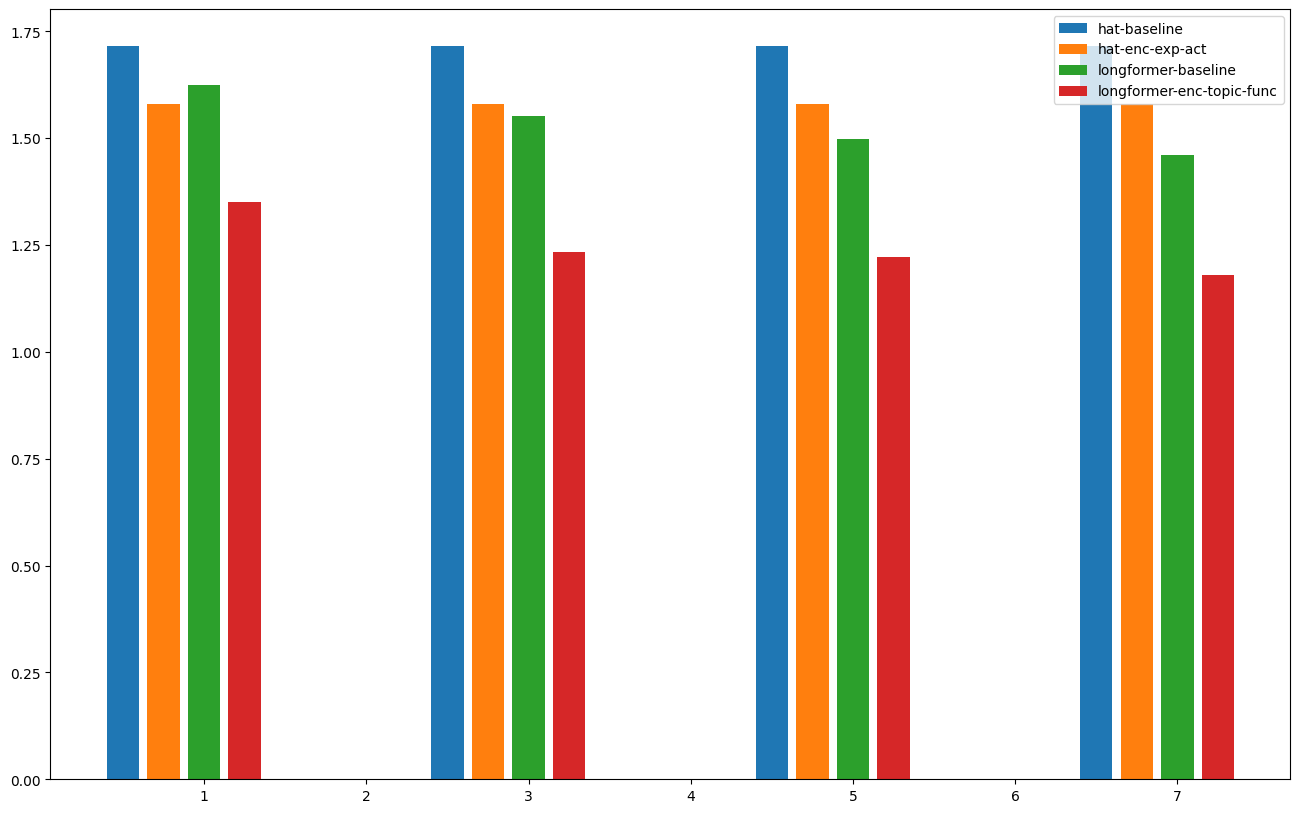

In [81]:
plt.figure(figsize=(16,10))
i=-0.5
for model, scores in models_scores.items():
    xs  = [x+i for x in range(1, 8, 2)]
    plt.bar(xs, [x[0] for x in scores], width=0.2, label=model)
    i+=0.25


plt.legend(loc='upper right')
plt.show()

-------

### Predicting on predicted labels:

In [40]:
eli5_df  = pd.read_pickle('../data/final_mace_predictions_testing_with_predictions.pkl')
eli5_dlg_quality_df = pd.read_csv('../../data/eli5_ds/annotation-results/MACE-measure/final_mace_rating_predictions.csv')
quality_scores = pd.Series(eli5_dlg_quality_df.rating_label.values, index = eli5_dlg_quality_df.task_id).to_dict()

eli5_df = eli5_df.groupby('task_id').agg({'turn_text': lambda rows: list(rows),
                                      'topic': lambda rows: list(rows)[0],
                                      'topic_func_label_predictions': lambda rows: list(rows),
                                      'dlg_act_label_predictions': lambda rows: list(rows),
                                      'exp_type_label' : lambda rows: list(rows),
                                      'exp_act_label_predictions': lambda rows: list(rows)}).reset_index()

eli5_df['labels'] = eli5_df.task_id.apply(lambda x: quality_scores[x])
eli5_df['input_texts'] = eli5_df.turn_text.apply(lambda row: [x['text'] for x in row])

eli5_df['exp_act_label'] =  eli5_df['exp_act_label_predictions'].apply(lambda row: [int(0) for x in row])
eli5_df['dlg_act_label'] =  eli5_df['dlg_act_label_predictions'].apply(lambda row: [int(0) for x in row])
eli5_df['topic_func_label'] =  eli5_df['topic_func_label_predictions'].apply(lambda row: [int(0) for x in row])

print('Maximum seq num:', max([len(x) for x in eli5_df.input_texts.tolist()]))
print('Maximum seq len:', max([len(turn.split(' ')) for turns in eli5_df.input_texts.tolist() for turn in turns]))
print('Data size:', len(eli5_df))

Maximum seq num: 40
Maximum seq len: 1303
Data size: 122


In [41]:
evaluated_models = {
#    'hat-baseline' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-baseline', {}),
#    'hat-enc-dlg-act' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-dlg-act-encoder/', {'dlg_act_label': {}}),
#     'hat-enc-exp-act' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-exp-act-encoder/', {'exp_act_label': {}}),
#     'hat-enc-topic-func' : ('../data/quality_models/single-fold/hat-models/single-fold-hat-model-topic-func-encoder/', {'topic_func_label':{}}),
#     'hat-enc-all' : ('../data/quality_models/single-fold/hat-models/hat-model-all-encoder/', {'dlg_act_label': {},
#                                                                                   'exp_act_label': {},
#                                                                                   'topic_func_label':{}}),
    
     'longformer-baseline' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline/', {}),
     'longformer-enc-dlg-act' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder/', {'dlg_act_label': {}}),
     'longformer-enc-exp-act' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-exp-act-encoder/', {'exp_act_label': {}}),
     'longformer-enc-topic-func' : ('../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-topic-func-encoder/', {'topic_func_label':{}}),
#     'longformer-enc-all' : ('../data/quality_models/single-fold/longformer-models/longformer-model-all-encoder/', {'dlg_act_label': {},
#                                                                                      'exp_act_label': {},
#                                                                                      'topic_func_label':{}})
}


In [42]:
#Single-fold evaluation
eval_scores = evaluate_all_models(evaluated_models, eli5_df,cross_fold=False)

feats_clms=dict_keys([])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-baseline//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  []
Using input_clm=input_texts
feats_clms=dict_keys(['dlg_act_label'])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder/ ------
Loading model: ../data/quality_models/single-fold/longformer-models/single-fold-longformer-model-dlg-act-encoder//0-fold/
Loading extra encoder configs from the config file...
Extra encoders:  [{'flow_model_hidden_size': 128, 'nhead': 1, 'nlayers': 3, 'num_tokens': 11}]
Using input_clm=input_texts
adding dlg_act_label to the flows
feats_clms=dict_keys(['exp_act_label'])
----- Evalauting model ../data/quality_models/single-fold/longformer-models/single-fold-longfo

In [43]:
print(tabulate([[key] + list(value) for key, value in eval_scores.items()] , headers=['Approach', 'RMSE', 'MAE']))

Approach                     RMSE    MAE
-------------------------  ------  -----
longformer-baseline         1.46   1.176
longformer-enc-dlg-act      1.273  1.026
longformer-enc-exp-act      1.366  1.187
longformer-enc-topic-func   1.181  0.943


In [39]:
print(tabulate([[key] + list(value) for key, value in eval_scores.items()] , headers=['Approach', 'RMSE', 'MAE']))

Approach                     RMSE    MAE
-------------------------  ------  -----
longformer-baseline         1.46   1.176
longformer-enc-dlg-act      1.281  1.031
longformer-enc-exp-act      1.364  1.187
longformer-enc-topic-func   1.18   0.943


In [103]:
print(tabulate([[key] + list(value) for key, value in eval_scores.items()] , headers=['Approach', 'RMSE', 'MAE']))

Approach                     RMSE    MAE
-------------------------  ------  -----
hat-baseline                1.716  1.433
hat-enc-dlg-act             1.603  1.37
hat-enc-exp-act             1.577  1.393
hat-enc-topic-func          1.753  1.466
hat-enc-all                 1.719  1.455
longformer-baseline         1.46   1.176
longformer-enc-dlg-act      1.273  1.026
longformer-enc-exp-act      1.366  1.187
longformer-enc-topic-func   1.181  0.943
longformer-enc-all          1.465  1.251


----------

#### Singificance Test:

In [17]:
from scipy import stats
#from statsmodels.stats import weightstats 
from scipy.stats import ttest_rel

#Check wither v1s are signficantly less than v2s
def check_sig(v1s, v2s, alpha=0.05):

    diff = list(map(lambda x1 , x2: x1 - x2, v1s, v2s))
    is_normal = stats.shapiro(diff)[1] > alpha
    
    if is_normal:
        print('Distribution is normal, so using ttest_rel')
        #tstat, pvalue, df = ttest_rel(v1s, v2s, alternative='greater')
        #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
        result = ttest_rel(v1s, v2s, alternative='greater')
        tstat, pvalue, df = result.statistics, result.pvalue, result.df
        print(tstat, pvalue)
        if tstat >=0:
            if (pvalue) <= alpha:
                return True
            else:
                return False
        else:
            return False

    else:
        print('Distribution is not normal, so using wilcoxon')
        ttest = stats.wilcoxon(v1s, v2s, alternative='greater')
        print(ttest)
        if ttest.statistic >=0:
            if (ttest.pvalue) <= alpha:
                return True
            else:
                return False
        else:
            return False

In [18]:
evaluated_models = {
    'hat-baseline' : ('../data/quality_models/hat-models/hat-model-baseline', {}),
    'hat-enc-exp-act' : ('../data/quality_models/hat-models/hat-model-exp-act-encoder/', {'exp_act_label': {'num_tokens':11, 'flow_model_hidden_size': 256, 'nhead':1, 'nlayers':3}}),
    'longformer-baseline' : ('../data/quality_models/longformer-models/longformer-model-baseline/', {}),
    'longformer-enc-exp-act' : ('../data/quality_models/longformer-models/longformer-model-exp-act-encoder/', {'exp_act_label': {'num_tokens':11, 'flow_model_hidden_size': 128, 'nhead':4, 'nlayers':6}}),
}

In [19]:
_, _, true_labels, hat_baseline_model_preds = evaluate_model(eli5_annotation_df, evaluated_models['hat-baseline'][0], 'hatformer', evaluated_models['hat-baseline'][1])
_, _, true_labels, hat_exp_encoder_model_preds = evaluate_model(eli5_annotation_df, evaluated_models['hat-enc-exp-act'][0], 'hatformer', evaluated_models['hat-enc-exp-act'][1])

----- Evalauting model ../data/quality_models/hat-models/hat-model-baseline ------
----- testing fold 0 ------
Loading model: ../data/quality_models/hat-models/hat-model-baseline/0-fold/
Extra encoders:  dict_values([])


Parameter 'function'=<function evaluate_model_on_fold.<locals>.<lambda> at 0x7f7b6c04f160> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


----- testing fold 1 ------
Loading model: ../data/quality_models/hat-models/hat-model-baseline/1-fold/
Extra encoders:  dict_values([])


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


----- testing fold 2 ------
Loading model: ../data/quality_models/hat-models/hat-model-baseline/2-fold/
Extra encoders:  dict_values([])


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


----- testing fold 3 ------
Loading model: ../data/quality_models/hat-models/hat-model-baseline/3-fold/
Extra encoders:  dict_values([])


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


----- testing fold 4 ------
Loading model: ../data/quality_models/hat-models/hat-model-baseline/4-fold/
Extra encoders:  dict_values([])


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[1.4618192356678288, 1.473890971507695, 1.3343427223167772, 1.4117480213327431, 1.3252707529048111]
----- Evalauting model ../data/quality_models/hat-models/hat-model-exp-act-encoder/ ------
----- testing fold 0 ------
Loading model: ../data/quality_models/hat-models/hat-model-exp-act-encoder//0-fold/
Extra encoders:  dict_values([{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}])


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
----- testing fold 1 ------
Loading model: ../data/quality_models/hat-models/hat-model-exp-act-encoder//1-fold/
Extra encoders:  dict_values([{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}])


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
----- testing fold 2 ------
Loading model: ../data/quality_models/hat-models/hat-model-exp-act-encoder//2-fold/
Extra encoders:  dict_values([{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}])


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
----- testing fold 3 ------
Loading model: ../data/quality_models/hat-models/hat-model-exp-act-encoder//3-fold/
Extra encoders:  dict_values([{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}])


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
----- testing fold 4 ------
Loading model: ../data/quality_models/hat-models/hat-model-exp-act-encoder//4-fold/
Extra encoders:  dict_values([{'num_tokens': 11, 'flow_model_hidden_size': 256, 'nhead': 1, 'nlayers': 3}])


  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


adding exp_act_label to the flows
[1.4322048569157984, 1.3731532843629626, 1.4886627748720904, 1.388803826993592, 1.260746213148131]


In [20]:
_, _, true_labels, longformer_baseline_model_preds = evaluate_model(eli5_annotation_df, evaluated_models['longformer-baseline'][0], 'longformer', evaluated_models['longformer-baseline'][1])
_, _, true_labels, longformer_exp_encoder_model_preds = evaluate_model(eli5_annotation_df, evaluated_models['longformer-enc-exp-act'][0], 'longformer', evaluated_models['longformer-enc-exp-act'][1])

----- Evalauting model ../data/quality_models/longformer-models/longformer-model-baseline/ ------
----- testing fold 0 ------
Loading model: ../data/quality_models/longformer-models/longformer-model-baseline//0-fold/
Extra encoders:  ModuleList()
Using input_clm=input_texts
----- testing fold 1 ------
Loading model: ../data/quality_models/longformer-models/longformer-model-baseline//1-fold/
Extra encoders:  ModuleList()
Using input_clm=input_texts
----- testing fold 2 ------
Loading model: ../data/quality_models/longformer-models/longformer-model-baseline//2-fold/
Extra encoders:  ModuleList()
Using input_clm=input_texts
----- testing fold 3 ------
Loading model: ../data/quality_models/longformer-models/longformer-model-baseline//3-fold/
Extra encoders:  ModuleList()
Using input_clm=input_texts
----- testing fold 4 ------
Loading model: ../data/quality_models/longformer-models/longformer-model-baseline//4-fold/
Extra encoders:  ModuleList()
Using input_clm=input_texts
[1.33927265759946

##### Hat-model vs Hat-baseline:

In [21]:
hat_baseline_mse = [mean_squared_error([x[0]], [x[1]], squared=False) for x in zip(true_labels, hat_baseline_model_preds)]
hat_model_mse    = [mean_squared_error([x[0]], [x[1]], squared=False) for x in zip(true_labels, hat_exp_encoder_model_preds)]
print('MSE: ', np.mean(hat_model_mse), np.mean(hat_baseline_mse))
check_sig(hat_baseline_mse, hat_model_mse, alpha=0.1)

MSE:  1.0927091165738902 1.1202387881227938
Distribution is not normal, so using wilcoxon
WilcoxonResult(statistic=56992.0, pvalue=0.21001154986849457)


False

In [22]:
hat_baseline_mae = [mean_absolute_error([x[0]], [x[1]]) for x in zip(true_labels, hat_baseline_model_preds)]
hat_model_mae    = [mean_absolute_error([x[0]], [x[1]]) for x in zip(true_labels, hat_exp_encoder_model_preds)]
print('MAE', np.mean(hat_model_mae), np.mean(hat_baseline_mae))
check_sig(hat_baseline_mae, hat_model_mae, alpha=0.1)

MAE 1.0927091165738902 1.1202387881227938
Distribution is not normal, so using wilcoxon
WilcoxonResult(statistic=56992.0, pvalue=0.21001154986849457)


False

##### Longformer-model vs longformer-baseline:

In [23]:
longformer_baseline_mse = [mean_squared_error([x[0]], [x[1]], squared=False) for x in zip(true_labels, longformer_baseline_model_preds)]
longformer_model_mse    = [mean_squared_error([x[0]], [x[1]], squared=False) for x in zip(true_labels, longformer_exp_encoder_model_preds)]
print(np.mean(longformer_model_mse), np.mean(longformer_baseline_mse))
check_sig(longformer_baseline_mse, longformer_model_mse, alpha=0.1)

0.9753592260644574 1.0142662260976543
Distribution is not normal, so using wilcoxon
WilcoxonResult(statistic=58251.0, pvalue=0.10788680833178338)


False

In [24]:
longformer_baseline_mae = [mean_absolute_error([x[0]], [x[1]]) for x in zip(true_labels, longformer_baseline_model_preds)]
longformer_model_mae    = [mean_absolute_error([x[0]], [x[1]]) for x in zip(true_labels, longformer_exp_encoder_model_preds)]
print(np.mean(longformer_model_mae), np.mean(longformer_baseline_mae))
check_sig(longformer_baseline_mae, longformer_model_mae, alpha=0.1)

0.9753592260644574 1.0142662260976543
Distribution is not normal, so using wilcoxon
WilcoxonResult(statistic=58251.0, pvalue=0.10788680833178338)


False